Import Modules

In [142]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

Hyperparameters

In [144]:
dataset_path = '~/datasets'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 10

# Model parameters
input_channels = 1
latent_dim = 20


Define the Encoder

In [146]:
# Devine the Encoder
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1)  # Output: (32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: (64, 7, 7)
        self.flatten = nn.Flatten()
        self.fc_mean = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_log_var = nn.Linear(64 * 7 * 7, latent_dim)

        self.relu = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

Define the Decoder

In [148]:
#Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: (32, 14, 14)
        self.deconv2 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1)  # Output: (1, 28, 28)

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 64, 7, 7)  # Reshape to spatial dimensions
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))  # Sigmoid to constrain outputs between 0 and 1
        return x

Define VAE Architecture 

In [150]:
class VAE(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(DEVICE)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var


Loss Function

In [152]:
def loss_function(reconstructed, original, mean, log_var):
    # Reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(reconstructed, original, reduction='sum')
    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

Train on MNIST

In [154]:
kwargs = {'num_workers': 1, 'pin_memory': True} 

# Define transformations
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(dataset_path, transform=mnist_transform, train=True, download=False)

# Filter dataset
#train_number = 0
#filtered_images = []
#filtered_labels = []
#for image, label in train_dataset:
    #if label == train_number:
        #filtered_images.append(image)
        #filtered_labels.append(label)
#filtered_dataset = TensorDataset(torch.stack(filtered_images), torch.tensor(filtered_labels))

# Create a new DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

# Define model
vae = VAE(input_channels, latent_dim).to(DEVICE)

# Optimizer
optimizer = Adam(vae.parameters(), lr=0.001)

# Training loop
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        images, _ = batch
        images = images.to(torch.float32)
        images = images.to(DEVICE)

        optimizer.zero_grad()
        reconstructed, mean, log_var = vae(images)
        loss = loss_function(reconstructed, images, mean, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataset)}")

# Saving the model and optimizer
torch.save({
    'model_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "demo_checkpoint.pth")

Epoch 1, Loss: 153.27779799804688
Epoch 2, Loss: 111.11452986653646
Epoch 3, Loss: 107.53707117513021
Epoch 4, Loss: 105.77988727213541
Epoch 5, Loss: 104.64051087239584
Epoch 6, Loss: 103.86989080403646
Epoch 7, Loss: 103.25198103841146
Epoch 8, Loss: 102.694903125
Epoch 9, Loss: 102.24201580403646
Epoch 10, Loss: 101.88797638346354


Load and Run Test Data

In [156]:
test_dataset = datasets.MNIST(dataset_path, transform=mnist_transform, train=False, download=False)
# Filter test dataset based on digit label
test_number = 0
filtered_test_dataset = [(x, y) for x, y in test_dataset if y == test_number]
test_loader  = DataLoader(dataset=filtered_test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs) # Change value for dataset to generate different numbers

try:
    # Reloading the model and optimizer
    checkpoint = torch.load("demo_checkpoint.pth")
    vae = VAE(input_channels=1, latent_dim=20)  # Reinitialize model
    vae.load_state_dict(checkpoint['model_state_dict'])
    vae.to(DEVICE)
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)  # Reinitialize optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except:
    print("Failed to load model!")

vae.eval()
test_images, _ = next(iter(test_loader))
test_images = test_images.to(DEVICE)
reconstructed, _, _ = vae(test_images)

C:\Users\Aes\AppData\Local\Temp\ipykernel_29420\3473606792.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("demo_checkpoint.pth")


Visualize Reconstruction

In [171]:
def show_image(original_batch, reconstructed_batch, index):
    # Extract the specific image and move to CPU
    original = original_batch[index].detach().cpu().numpy().squeeze()
    reconstructed = reconstructed_batch[index].detach().cpu().numpy().squeeze()
    
    # Create the plot
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    # Original image
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Reconstructed image
    axes[1].imshow(reconstructed, cmap='gray')
    axes[1].set_title("Generated")
    axes[1].axis('off')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

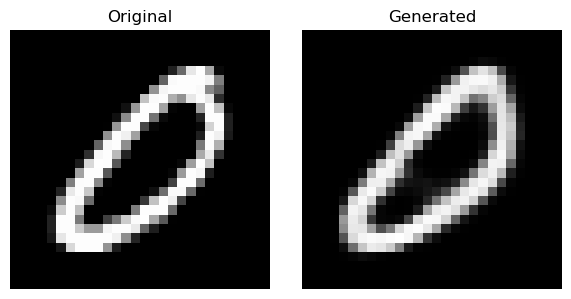

In [173]:
show_image(test_images, reconstructed, index=15)